Diabetic Retinopathy

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import os
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns

In [2]:
for dirname, _, filenames in os.walk('gaussian_filtered_images/images'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
# Function to calculate learning rate
def lr_rate(epoch, lr):
    if epoch < 5:
        lr = 0.0001
        return lr
    elif 5 <= epoch <= 10:
        lr = 0.00005
        return lr
    else:
        lr = lr * (epoch / (1 + epoch))
        return lr

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [6]:
# Build and compile the model
model = tf.keras.Sequential([
    efn.EfficientNetB0(
        input_shape=(224,224, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [8]:
# Train the model
history = model.fit_generator(train_data,
                              validation_data=valid_data,
                              callbacks=[lr_callback, early_stop],
                              epochs=15,
                              verbose=1
                             )

C:\Users\AyhanÇavdar\AppData\Local\Temp\ipykernel_14776\1980824890.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/15
92/92 [==============================] - 195s 2s/step - loss: 0.7243 - acc: 0.7393 - val_loss: 0.7474 - val_acc: 0.7401 - lr: 1.0000e-04
Epoch 2/15
92/92 [==============================] - 193s 2s/step - loss: 0.6519 - acc: 0.7622 - val_loss: 0.6962 - val_acc: 0.7715 - lr: 1.0000e-04
Epoch 3/15
92/92 [==============================] - 223s 2s/step - loss: 0.5914 - acc: 0.7878 - val_loss: 0.6080 - val_acc: 0.7839 - lr: 1.0000e-04
Epoch 4/15
92/92 [==============================] - 209s 2s/step - loss: 0.5520 - acc: 0.7987 - val_loss: 0.5830 - val_acc: 0.7907 - lr: 1.0000e-04
Epoch 5/15
92/92 [==============================] - 225s 2s/step - loss: 0.5204 - acc: 0.8038 - val_loss: 0.5646 - val_acc: 0.7962 - lr: 1.0000e-04
Epoch 6/15
92/92 [==============================] - 207s 2s/step - loss: 0.4862 - acc: 0.8270 - val_loss: 0.5672 - val_acc: 0.7798 - lr: 5.0000e-05
Epoch 7/15
92/92 [==============================] - 206s 2s/step - loss: 0.4599 - acc: 0.8243 - val_loss: 0.5310

In [9]:
# Plot training curves
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

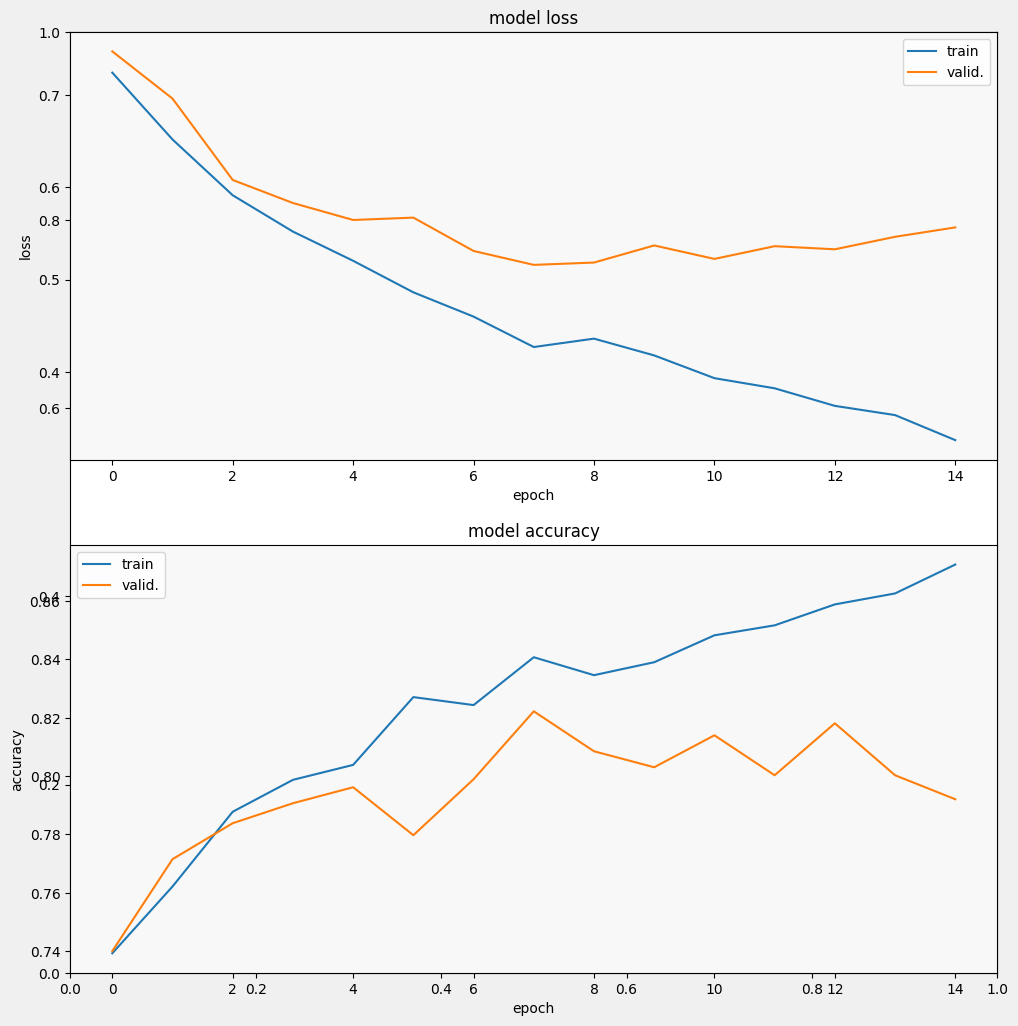

In [10]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'accuracy',
    212
)

In [11]:
# Evaluate the model
y_actual = valid_data.labels
y_predicted_prob = model.predict(valid_data)
y_predicted = np.argmax(y_predicted_prob, axis=1)

# Calculate the F1 score and AUC
f1 = f1_score(y_actual, y_predicted, average='macro')
auc = roc_auc_score(y_actual, y_predicted_prob, average='macro', multi_class='ovo')

# Print the results
print('F1 score:', f1)
print('AUC:', auc)

23/23 [==============================] - 16s 635ms/step
F1 score: 0.18684304681781053
AUC: 0.5085188874720071


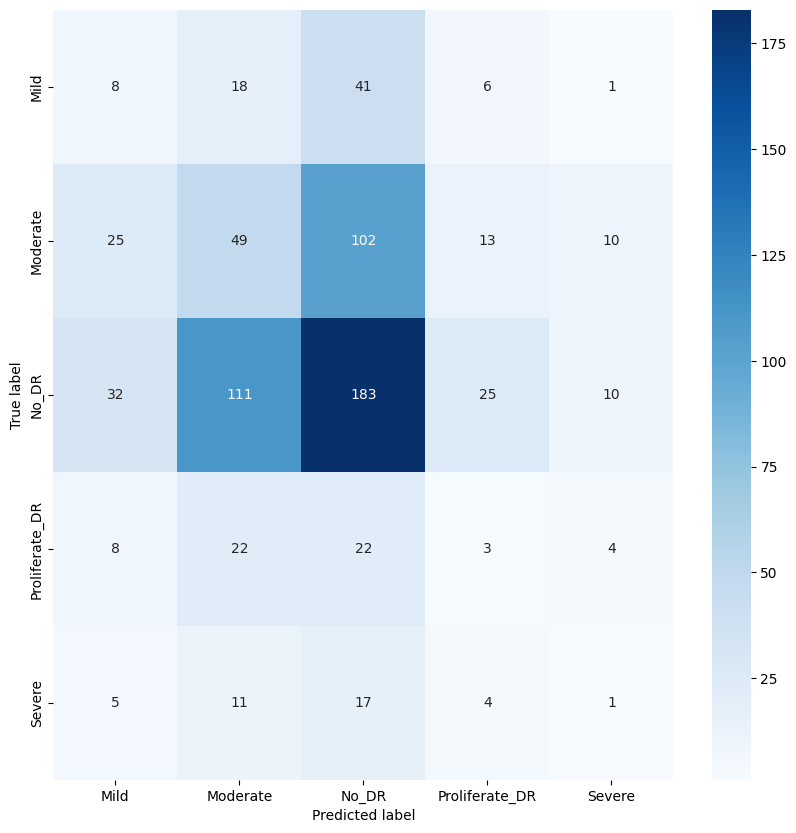

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(y_actual, y_predicted)

# Define the class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Plot the confusion matrix with labels
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()